# Infraestructure Manager revenue maximization with GSA

## 0. Load libraries

In [97]:
%load_ext autoreload
%autoreload 2

import numpy as np

from benchmarks.railway import Solution, RevenueMaximization
from benchmarks.generator import get_schedule_request, get_revenue_behaviour
from src.entities import GSA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Generate service requests

As an example, we will use the Spanish south high-speed railway corridor.



In [98]:
south_corridor =   {"MAD": {
                        "CIU": {
                            "COR": {
                                "SEV": {
                                    "CAD": {}
                                       },
                                "PGE": {
                                    "ANT": {
                                        "GRA": {},
                                        "MAL": {}
                                            }
                                        }
                                    }
                                }
                            }
                        }

In [99]:
np.random.seed(seed=28)

schedule = get_schedule_request(south_corridor, 5)
revenue = get_revenue_behaviour(schedule)

schedule, revenue

({1: {'CIU': [1302, 1302],
   'COR': [1364, 1369],
   'PGE': [1481, 1487],
   'ANT': [1575, 1580],
   'GRA': [1628, 1628]},
  2: {'MAD': [606, 606],
   'CIU': [679, 685],
   'COR': [797, 800],
   'SEV': [905, 912],
   'CAD': [995, 995]},
  3: {'MAD': [933, 933],
   'CIU': [1033, 1039],
   'COR': [1091, 1098],
   'SEV': [1136, 1140],
   'CAD': [1170, 1170]},
  4: {'MAD': [963, 963],
   'CIU': [1005, 1008],
   'COR': [1115, 1118],
   'PGE': [1203, 1206],
   'ANT': [1234, 1238],
   'GRA': [1281, 1281]},
  5: {'COR': [537, 537],
   'PGE': [614, 620],
   'ANT': [730, 737],
   'MAL': [762, 762]}},
 {1: {'canon': 302.5,
   'k': 2.88,
   'dt_max_penalty': 42.35,
   'tt_max_penalty': 19.66},
  2: {'canon': 371.25,
   'k': 19.02,
   'dt_max_penalty': 51.97,
   'tt_max_penalty': 24.13},
  3: {'canon': 302.5,
   'k': 1.1,
   'dt_max_penalty': 42.35,
   'tt_max_penalty': 19.66},
  4: {'canon': 396.0,
   'k': 19.73,
   'dt_max_penalty': 55.44,
   'tt_max_penalty': 20.59},
  5: {'canon': 297.0,
   'k

In [106]:
np.random.seed(seed=28)

# Dummy schedule
schedule = {1: {'MAD': [0, 0], 'BAR': [148, 152], 'FIG': [180, 180]},
            2: {'MAD': [8, 8], 'ZAR': [28, 30], 'BAR': [165, 167], 'FIG': [210, 210]},
            3: {'MAD': [30, 30], 'BAR': [180, 182], 'FIG': [225, 225]}}

revenue = get_revenue_behaviour(schedule)

schedule, revenue

({1: {'MAD': [0, 0], 'BAR': [148, 152], 'FIG': [180, 180]},
  2: {'MAD': [8, 8], 'ZAR': [28, 30], 'BAR': [165, 167], 'FIG': [210, 210]},
  3: {'MAD': [30, 30], 'BAR': [180, 182], 'FIG': [225, 225]}},
 {1: {'canon': 222.75,
   'k': 1.05,
   'dt_max_penalty': 31.18,
   'tt_max_penalty': 28.96},
  2: {'canon': 242.0,
   'k': 1.03,
   'dt_max_penalty': 33.88,
   'tt_max_penalty': 20.97},
  3: {'canon': 198.0,
   'k': 1.18,
   'dt_max_penalty': 27.72,
   'tt_max_penalty': 25.74}})

In [118]:
sm = RevenueMaximization(schedule, revenue, safe_headway=10)

In [119]:
gsa_algo = GSA(objective_function=sm.get_fitness_gsa,
               is_feasible=sm.feasible_services_times,
               r_dim=len(sm.boundaries.real),
               d_dim=0,
               boundaries=sm.boundaries)

In [120]:
import cProfile as profile
import time

pr = profile.Profile()
pr.disable()

#gsa_algo.set_seed(seed=28)

pop_size = 20

start = time.time()
pr.enable()
training_history = gsa_algo.optimize(population_size=pop_size,
                                     iters=100,
                                     chaotic_constant=True,
                                     repair_solution=False,
                                     initial_population=sm.get_initial_population(pop_size))
pr.disable()
print(f"Elapsed time: {time.time() - start}")

pr.dump_stats('profile.pstat')

Initial population: [<src.entities.Solution object at 0x2a5092700>, <src.entities.Solution object at 0x2a50b4d30>, <src.entities.Solution object at 0x2a50b4ca0>, <src.entities.Solution object at 0x2a50b4490>, <src.entities.Solution object at 0x2a50b44f0>, <src.entities.Solution object at 0x2a50b47c0>, <src.entities.Solution object at 0x2a50b4460>, <src.entities.Solution object at 0x2a50b4c70>, <src.entities.Solution object at 0x2a50b46a0>, <src.entities.Solution object at 0x2a50b4a30>, <src.entities.Solution object at 0x2a50b4700>, <src.entities.Solution object at 0x2a50b42b0>, <src.entities.Solution object at 0x2a50b4b80>, <src.entities.Solution object at 0x2a50b45b0>, <src.entities.Solution object at 0x2a50b4b20>, <src.entities.Solution object at 0x2a50b4880>, <src.entities.Solution object at 0x2a50b4130>, <src.entities.Solution object at 0x2a50b4760>, <src.entities.Solution object at 0x2a50b4100>, <src.entities.Solution object at 0x2a50b45e0>]
GSA is optimizing  "get_fitness_gsa"
rv

In [121]:
sm.best_solution.real

array([-10.        , 152.00000003,   7.99750614,  30.        ,
       167.        ,  30.00171545, 191.8925832 ])

In [122]:
sm.requested_schedule

{1: {'MAD': [0, 0], 'BAR': [148, 152], 'FIG': [180, 180]},
 2: {'MAD': [8, 8], 'ZAR': [28, 30], 'BAR': [165, 167], 'FIG': [210, 210]},
 3: {'MAD': [30, 30], 'BAR': [180, 182], 'FIG': [225, 225]}}

In [123]:
sm.operational_times

{1: [148, 4, 28], 2: [20, 2, 135, 2, 43], 3: [150, 2, 43]}

In [124]:
# Get last value in column 'Real' of training_history
best_solution = training_history.iloc[-1]['Real']
best_solution

array([-10.        , 151.99999999,   8.01115651,  30.        ,
       167.        ,  30.00120765, 191.89339018])

In [125]:
sm.boundaries.real

[[-10, 10],
 [142.0, 152.0],
 [-2, 18],
 [30.002830131791193, 40],
 [166.99999999197178, 176.99999999197178],
 [20, 40],
 [181.95018475146813, 191.95018475146813]]

In [126]:
sm.is_feasible(np.round(best_solution), np.array([1, 1, 1]))

True

In [130]:
sm.get_revenue(Solution(real=np.array(best_solution), discrete=np.array([1, 1, 1])))

631.5697597562066

In [131]:
sm.get_revenue(sm.best_solution)

631.569985093929

In [132]:
training_history

,Iteration,Fitness,Accuracy,ExecutionTime,Discrete,Real
0,0,609.270093,0,0.007769,[],"[0.7605655031064646, 153.8835627320529, 10.906..."
1,1,625.119135,0,0.019687,[],"[-10.0, 152.0, 8.284851359660333, 30.0, 167.0,..."
2,2,625.119135,0,0.031354,[],"[-37.18184161179378, 148.52436495179248, 8.598..."
3,3,626.160169,0,0.042910,[],"[-10.0, 152.0, 9.561181519073944, 30.368899463..."
4,4,626.160169,0,0.054370,[],"[-18.62812389728465, 151.93065212656617, 12.14..."
...,...,...,...,...,...,...
95,95,631.569971,0,0.924527,[],"[-10.0, 152.0000013707382, 8.000346631007938, ..."
96,96,631.569971,0,0.932534,[],"[-10.0, 152.0000013707382, 8.000346631007938, ..."
97,97,631.569985,0,0.940646,[],"[-10.0, 152.00000002596863, 7.997506136483738,..."
98,98,631.569985,0,0.948518,[],"[-10.0, 151.999999986684, 8.011156514643877, 2..."


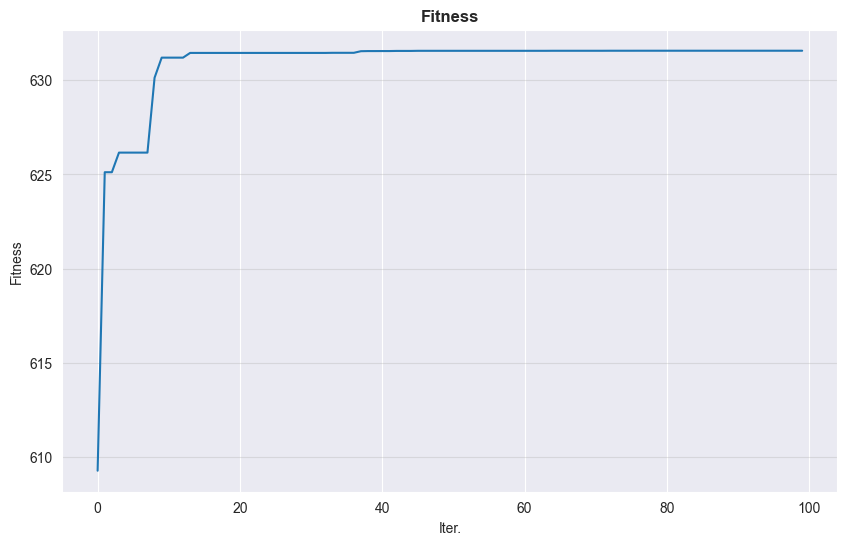

In [133]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Fitness", fontweight='bold')

# ax.set_ylim(min(global_train_hist["Fitness"]), max(global_train_hist["Fitness"]))
    
sns.lineplot(ax=ax,
             data=training_history,
             x="Iteration",
             y="Fitness",
             legend=True)

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)

ax.set_xlabel("Iter.")
ax.set_ylabel("Fitness")

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)

In [53]:
!snakeviz profile.pstat

snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2FUsers%2Fdavid%2FPycharmProjects%2FGSA_M%2Fnotebooks%2Fprofile.pstat
^C

Bye!


In [134]:
sum([revenue[service]['canon'] for service in revenue])

662.75